In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras_preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'PlantVillage4'
width=256
height=256
depth=3


In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [6]:
image_size = len(image_list)

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [16]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

In [12]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

NameError: name 'model' is not defined

In [19]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
188/188 [==============================] - 544s 3s/step - loss: 0.3092 - accuracy: 0.1573 - val_loss: 0.3299 - val_accuracy: 0.0549
Epoch 2/25
188/188 [==============================] - 531s 3s/step - loss: 0.0783 - accuracy: 0.4633 - val_loss: 0.2839 - val_accuracy: 0.0702
Epoch 3/25
188/188 [==============================] - 524s 3s/step - loss: 0.0639 - accuracy: 0.5841 - val_loss: 0.9973 - val_accuracy: 0.0642
Epoch 4/25
188/188 [==============================] - 4186s 22s/step - loss: 0.1104 - accuracy: 0.4107 - val_loss: 0.1454 - val_accuracy: 0.3044
Epoch 5/25
188/188 [==============================] - 641s 3s/step - loss: 0.0798 - accuracy: 0.5458 - val_loss: 0.4386 - val_accuracy: 0.1092
Epoch 6/25
188/188 [==============================] - 610s 3s/step - loss: 0.0668 - accuracy: 0.6088 - val_loss: 0.1736 - val_accuracy: 0.2535
Epoch 7/25
188/188 [==============================] - 551s 3s/step - loss: 0.0548 - accuracy: 0.6815 - val_loss: 0.0563 - val_accuracy: 0.65

In [29]:
model.save("A4Model")

INFO:tensorflow:Assets written to: A4Model\assets


INFO:tensorflow:Assets written to: A4Model\assets


In [12]:
from tensorflow.keras import models
model1=models.load_model("A4Model")

In [13]:
scores=model1.evaluate(x_test,y_test)
print(f"test accuracy:{scores[1]*100}")

48/48 [==============================] - 28s 534ms/step - loss: 0.0226 - accuracy: 0.8690
test accuracy:86.8960976600647


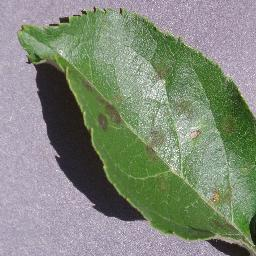

In [16]:
from IPython.display import Image
Image('apple_scab.jpg')

In [17]:
img = convert_image_to_array('apple_scab.jpg')

img = np.array(img, dtype=np.float16) / 225.0

img.resize(1,256,256,3)

In [18]:
res = model1.predict(img)

res

1/1 [==============================] - 1s 726ms/step


array([[9.91956949e-01, 1.48878189e-05, 2.70193832e-05, 5.57974679e-03,
        4.69225721e-04, 1.15427190e-06, 5.15886950e-06, 5.13849227e-06,
        2.27989091e-07, 4.68697326e-05, 5.70327785e-08, 2.49827553e-06,
        1.14638794e-07, 7.72447828e-10, 6.06167259e-06, 3.53055316e-06,
        5.25000178e-05, 1.05909921e-08, 1.11076251e-05, 3.78995058e-09,
        1.00878933e-04, 3.17441154e-05, 4.62641623e-07, 4.55391280e-09,
        1.32472605e-05, 3.56261880e-05, 1.49209372e-05, 1.21872930e-03,
        2.54765524e-07, 2.58697582e-07, 1.01277135e-06, 1.87222777e-05,
        2.09571124e-04, 3.99940262e-07, 1.69209045e-04, 4.20658495e-08,
        5.27022204e-09, 2.76192327e-06]], dtype=float32)

In [19]:
print(label_binarizer.inverse_transform(res))

['Apple___Apple_scab']
